In [1]:
import Parity_Data_Generator
import numpy as np
from pyESN import ESN
import time

N = 4000   # number of datapoints
n = 3       # n-parity
timescale = 50
rng = np.random.RandomState(42)

def produceTrainingData(i):
    bits, parity, target = Parity_Data_Generator.generateParityData(N, n, timescale=timescale, 
                                                                    randomstate=np.random.RandomState(i))

    # Divide in training and test data
    traintest_cutoff = int(np.ceil(0.7 * len(bits)))
    train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
    train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
    train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]
    return train_bits, test_bits, train_parity, test_parity, train_targets, test_targets

In [5]:
trials = 1
num_neurons_slow = 300
num_neurons_fast = 50

delta_t = [0.1]

l_rate = np.linspace(0.1, 1, num=10)
# l_rate =[0.2]
# l_rate = [0.1,0.2,0.3]

# sp_rad = np.linspace(0.9, 1.0, num=5)
sp_rad = np.linspace(0.1, 1, num=10)
# sp_rad = [0.8]


run_time = time.time()
iterations, iterationcount = trials*len(sp_rad)*len(l_rate)*len(delta_t), 0

delta_t_error = []
for dt in delta_t:
    all_errors = [{} for _ in range(trials)] # empty dict
    for i in range(trials):
        errors = []
        # produce training and testing data
        train_bits, test_bits, train_parity, test_parity, train_targets, test_targets = produceTrainingData(i)
        for l in l_rate:
            for s in sp_rad:
                print("Neurons:", num_neurons_slow,"Leak-rate:",l,"Spectral-radius:",s,"Delta_t:",dt)
                ## Create slow ESN
                nParityESN = ESN(n_inputs=1,
                      n_outputs=1,
                      n_reservoir=num_neurons_slow,  
                      spectral_radius=s,  
                      leak_rate= l,   
                      delta_t= dt,
                      sparsity=0.95,
                      noise=0.01,
                      input_shift=0,
                      input_scaling=3,  
                      teacher_forcing=False,
                      teacher_scaling=1.12,
                      teacher_shift=-0.7,
                      random_state=rng,
                      silent=False)
                nParityESN.fit(train_bits, train_parity)

                ## Get trainingdata for output-ESN from parity-ESN
                new_train_bits, new_test_bits, new_train_parity, new_test_parity, new_train_targets, new_test_targets = produceTrainingData(i+123)

                predictedParityTrain = nParityESN.predict(new_train_bits)
                predictedParityTest = nParityESN.predict(new_test_bits)

                outputESN = ESN(n_inputs=1,
                          n_outputs=1,
                          n_reservoir=num_neurons_fast,  
                          spectral_radius=s,  
                          leak_rate= l,   
                          delta_t= dt,
                          sparsity=0.95,
                          noise=0.01,
                          input_shift=0,
                          input_scaling=3, 
                          teacher_forcing=False,
                          teacher_scaling=1.12,
                          teacher_shift=-0.4,
                          random_state=rng,
                          silent=False)

                outputESN.fit(predictedParityTrain, new_train_targets)
                predictedOutput = outputESN.predict(predictedParityTest)

                print("Testing error")
                test_error = np.sqrt(np.mean((predictedOutput - new_test_targets) ** 2))
                print(test_error)

                errors.append(test_error)
                iterationcount = iterationcount + 1
                print("--- Progress: {:.2f}% --- {:.2f} minutes ---".format(iterationcount/iterations*100, ((time.time() - run_time)/60) ))
        ## Save leak-rate,spectral-radius and error in dictionary
        all_errors[i] = errors

    ### Average errors
    errors_averaged_over_trials = np.zeros(len(sp_rad)*len(l_rate))
    for i in range(len(all_errors)):
        e = all_errors[i]
        errors_averaged_over_trials = np.add(errors_averaged_over_trials, np.array(e))
    errors_averaged_over_trials = np.divide(errors_averaged_over_trials, trials)
    
    delta_t_error.append(errors_averaged_over_trials)
            
print("Total time for Testbench:")
print("--- {:.2f} seconds ---".format(time.time() - run_time))
print("--- {:.2f} minutes ---".format(((time.time() - run_time)/60)))

Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.1 Delta_t: 0.1
harvesting states...
fitting...
training error:
0.38789158714
harvesting states...
fitting...
training error:
0.385242656148
Testing error
0.383507550912
--- Progress: 1.00% --- 0.45 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.2 Delta_t: 0.1
harvesting states...
fitting...
training error:
0.347456050944
harvesting states...
fitting...
training error:
0.350313497183
Testing error
0.351395939092
--- Progress: 2.00% --- 0.89 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.3 Delta_t: 0.1
harvesting states...
fitting...
training error:
0.342276639676
harvesting states...
fitting...
training error:
0.346786081283
Testing error
0.341943842671
--- Progress: 3.00% --- 1.34 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.4 Delta_t: 0.1
harvesting states...
fitting...
training error:
0.332627729879
harvesting states...
fitting...
training error:
0.342566952351
Testing error
0.347526187452
--- Progre

In [6]:
import pickle
#### Save Data
# with open('dataSameLeakAndSpectErrors.p','wb') as outputFile:
#     pickle.dump(delta_t_error,outputFile)
#     pickle.dump(num_neurons_slow, outputFile)
#     pickle.dump(num_neurons_fast, outputFile)
#     pickle.dump(delta_t, outputFile)
#     pickle.dump(l_rate, outputFile)
#     pickle.dump(sp_rad, outputFile)
#### Load Data
with open('dataSameLeakAndSpectErrors.p', 'rb') as inputFile:
    delta_t_error = pickle.load(inputFile)
    num_neurons_slow = pickle.load(inputFile)
    num_neurons_fast = pickle.load(inputFile)
    delta_t = pickle.load(inputFile)
    l_rate = pickle.load(inputFile)
    sp_rad = pickle.load(inputFile)

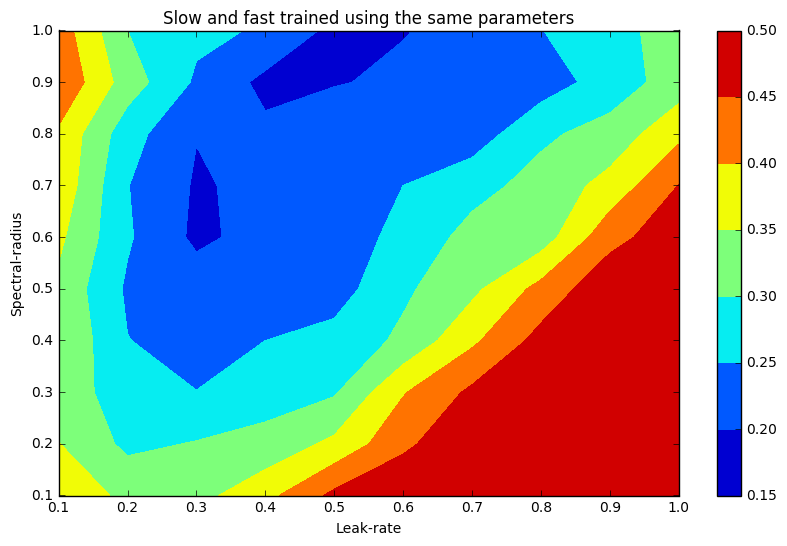

In [12]:
### Errors
from matplotlib import pyplot
%matplotlib inline
xx, yy = np.meshgrid(l_rate, sp_rad)
pyplot.figure(figsize=(10,6))
pyplot.subplot(111)
pyplot.contourf(xx,
                yy,delta_t_error[0].reshape(10,10).T)
pyplot.title("Slow and fast trained using the same parameters")
pyplot.xlabel("Leak-rate")
pyplot.ylabel("Spectral-radius")
pyplot.colorbar()